In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/transactional-and-nottransactional-dataset/TransactionalAndNotTransactional.csv


 <a id="1"></a>
# <p style="background-color:#696969;font-family:newtimeroman;color:#FFFFFF;font-size:110%;text-align:center;">IMPORTING LIBRARIES</p>

In [2]:
! pip install joblib

In [26]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap

from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
from joblib import Parallel, delayed

<a id="2"></a>
# <p style="background-color:#696969;font-family:newtimeroman;color:#FFFFFF;font-size:110%;text-align:center;">LOADING DATA</p>

In [27]:
#Loading data
data = pd.read_csv("/kaggle/input/transactional-and-nottransactional-dataset/TransactionalAndNotTransactional.csv")
data

,Message,Label
0,Important notice: Account verification required.,NotTransaction
1,VISA8182 21:09 crediting 7093.52 USD from Jame...,Transaction
2,Notification: Our branch hours have been updat...,NotTransaction
3,Thank you for choosing us as your banking part...,NotTransaction
4,Congratulations! You've reached a milestone wi...,NotTransaction
...,...,...
1055686,Transaction Declined: Insufficient funds. Your...,NotTransaction
1055687,Transaction Failed: We regret to inform you th...,NotTransaction
1055688,Payment Failure: Insufficient balance. Your pa...,NotTransaction
1055689,Transaction Error: We encountered an issue pro...,NotTransaction


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055691 entries, 0 to 1055690
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   Message  1055691 non-null  object
 1   Label    1055691 non-null  object
dtypes: object(2)
memory usage: 16.1+ MB


In [29]:
data.head()

,Message,Label
0,Important notice: Account verification required.,NotTransaction
1,VISA8182 21:09 crediting 7093.52 USD from Jame...,Transaction
2,Notification: Our branch hours have been updat...,NotTransaction
3,Thank you for choosing us as your banking part...,NotTransaction
4,Congratulations! You've reached a milestone wi...,NotTransaction


Text(0, 0.5, 'Number of Data points')

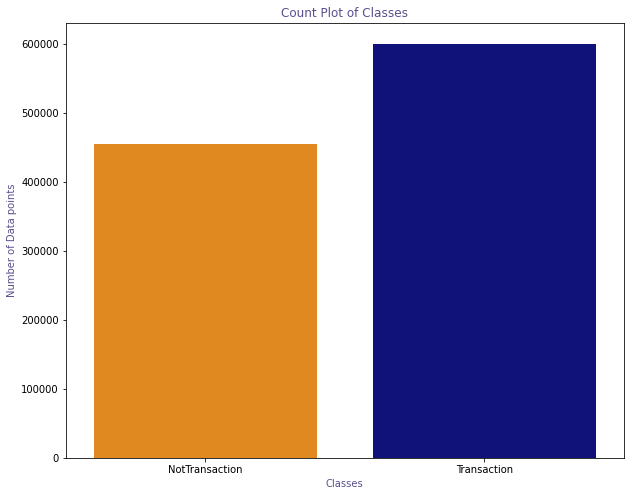

In [30]:
#Palette
cols= ["#FF8C00", "#00008B"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(10,8))
fg = sns.countplot(x= data["Label"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

 <a id="3.1"></a>
# <p style="background-color:#696969;font-family:newtimeroman;color:#FFFFFF;text-align:center;font-size:110%;">FEATURE ENGINEERING</p>

For the purpose of data exploration, I am creating new features 

* No_of_Characters: Number of characters in the text message
* No_of_Words: Number of words in the text message
* No_of_sentence: Number of sentences in the text message  

In [31]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Message"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Message"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Message"]), axis=1).apply(len)

data.describe().T

#PS. At this step, I tokenised the words and sentences and used the length of the same. 

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,1055691.0,105.977442,39.797750,2.0,75.0,95.0,132.0,910.0
No_of_Words,1055691.0,19.937397,7.364092,1.0,13.0,20.0,25.0,196.0
No_of_sentence,1055691.0,2.470672,0.937523,1.0,2.0,2.0,3.0,38.0


<Figure size 864x576 with 0 Axes>

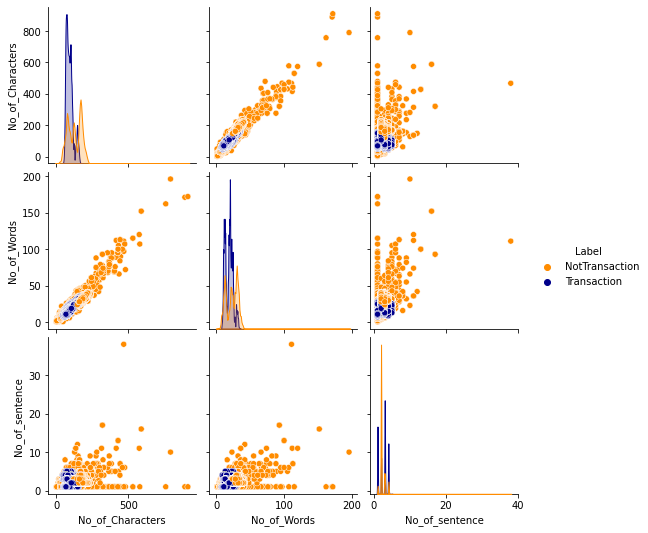

In [32]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Label",palette=cols)
plt.show(fg)

In [33]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<350)]
data.shape

(1055644, 5)

<Figure size 864x576 with 0 Axes>

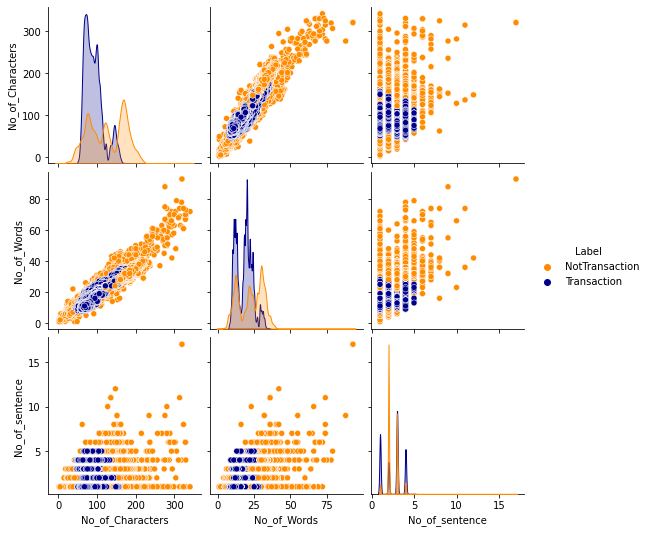

In [34]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Label",palette=cols)
plt.show(fg)

<a id="4.1"></a>
# <p style="background-color:#696969;font-family:newtimeroman;color:#FFFFFF;text-align:center;font-size:110%;">CLEANING TEXT</p>

The data cleaning process NLP is crucial. The computer doesn’t understand the text. for the computer, it is just a cluster of symbols. To further process the data we need to make the data cleaner. 

* In the first step we extract only the alphabetic characters by this we are removing punctuation and numbers. 
* In the next step, we are converting all the characters into lowercase. 

This text will be then used in further procrssing

In [35]:
#Lets have a look at a sample of texts before cleaning
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Message"][:5], sep = "\n")

 The First 5 Texts:
Important notice: Account verification required.
VISA8182 21:09 crediting 7093.52 USD from James Ali Balance: 17811.37 USD
Notification: Our branch hours have been updated. Check our website for the latest information.
Thank you for choosing us as your banking partner! We strive to provide the best service to meet your financial needs.
Congratulations! You've reached a milestone with us. As a token of our appreciation, enjoy a special discount on your next purchase.


In [36]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Message"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
important notice account verification required
visa crediting usd from james ali balance usd
notification our branch hours have been updated check our website for the latest information
thank you for choosing us as your banking partner we strive to provide the best service to meet your financial needs
congratulations you ve reached a milestone with us as a token of our appreciation enjoy a special discount on your next purchase


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<a id="4.2"></a>
# <p style="background-color:#696969;font-family:newtimeroman;color:#FFFFFF;text-align:center;font-size:80%;border-radius:20px 60px;">TOKENIZATION</p>

**Tokenization** is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words. 
I am splitting the Clean_Text into words at this step.

In [37]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['important', 'notice', 'account', 'verification', 'required']
['visa', 'crediting', 'usd', 'from', 'james', 'ali', 'balance', 'usd']
['notification', 'our', 'branch', 'hours', 'have', 'been', 'updated', 'check', 'our', 'website', 'for', 'the', 'latest', 'information']
['thank', 'you', 'for', 'choosing', 'us', 'as', 'your', 'banking', 'partner', 'we', 'strive', 'to', 'provide', 'the', 'best', 'service', 'to', 'meet', 'your', 'financial', 'needs']
['congratulations', 'you', 've', 'reached', 'a', 'milestone', 'with', 'us', 'as', 'a', 'token', 'of', 'our', 'appreciation', 'enjoy', 'a', 'special', 'discount', 'on', 'your', 'next', 'purchase']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<a id="4.3"></a>
# <p style="background-color:#696969;font-family:newtimeroman;color:#FFFFFF;text-align:center;font-size:110%">REMOVING STOPWORDS</p>

**Stopwords** are frequently occurring words(*such as few, is, an, etc*). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing. 

In [38]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['important', 'notice', 'account', 'verification', 'required']
['visa', 'crediting', 'usd', 'james', 'ali', 'balance', 'usd']
['notification', 'branch', 'hours', 'updated', 'check', 'website', 'latest', 'information']
['thank', 'choosing', 'us', 'banking', 'partner', 'strive', 'provide', 'best', 'service', 'meet', 'financial', 'needs']
['congratulations', 'reached', 'milestone', 'us', 'token', 'appreciation', 'enjoy', 'special', 'discount', 'next', 'purchase']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<a id="4.4"></a>
# <p style="background-color:#696969;font-family:newtimeroman;color:#FFFFFF;text-align:center;font-size:110%">LEMMATIZATION</p>

**Stemming** is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word. 

**lemmatization** also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English. 

In [39]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    # No need to tokenize here, assuming text is already a list of words
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['important', 'notice', 'account', 'verification', 'require']
['visa', 'credit', 'usd', 'jam', 'ali', 'balance', 'usd']
['notification', 'branch', 'hours', 'update', 'check', 'website', 'latest', 'information']
['thank', 'choose', 'us', 'bank', 'partner', 'strive', 'provide', 'best', 'service', 'meet', 'financial', 'need']
['congratulations', 'reach', 'milestone', 'us', 'token', 'appreciation', 'enjoy', 'special', 'discount', 'next', 'purchase']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<a id="5"></a>
# <p style="background-color:#696969;font-family:newtimeroman;font-size:110%;color:#FFFFFF;text-align:center">VECTORIZE</p>

**TF-IDF** in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents)
Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t))
I will be using TfidfVectorizer() to vectorize the preprocessed data. 

**Steps in the Vectorizing:**
* Creating a corpus of lemmatized text
* Converting the corpus in vector form
* Label Encoding the classes in Target
 

In [40]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
important notice account verification require
visa credit usd jam ali balance usd
notification branch hours update check website latest information
thank choose us bank partner strive provide best service meet financial need
congratulations reach milestone us token appreciation enjoy special discount next purchase


In [41]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(corpus)
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [42]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Label"] = label_encoder.fit_transform(data["Label"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<a id="6"></a>
# <p style="background-color:#696969;font-family:newtimeroman;font-size:110%;color:#FFFFFF;text-align:center;">BUILDING AND TRAIN</p>

**Steps involved in the Model Building**
* Setting up features and target as X and y
* Splitting the testing and training sets
* Build the model .
* Fit the models on training data
* Get the validation and cross-validation on the training set 

In [43]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Label"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [44]:
# Function to train and evaluate a model
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    result = [model_name, accuracy, precision, recall, f1]
    return result

# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Bagging Classifier": BaggingClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Decision Tree Classifier": DecisionTreeClassifier()
}

In [45]:
# Train and evaluate each model separately
results = []

In [46]:
# Logistic Regression
results.append(train_and_evaluate(models["Logistic Regression"], "Logistic Regression"))
print(f"Logistic Regression Results: {results[-1]}")

Logistic Regression Results: ['Logistic Regression', 0.9999905271184916, 0.9999905272764031, 0.9999905271184916, 0.9999905271060082]


In [47]:
# # Support Vector Machine
# results.append(train_and_evaluate(models["Support Vector Machine"], "Support Vector Machine"))
# print(f"Support Vector Machine Results: {results[-1]}")

In [ ]:
# # AdaBoost Classifier
# results.append(train_and_evaluate(models["AdaBoost Classifier"], "AdaBoost Classifier"))
# print(f"AdaBoost Classifier Results: {results[-1]}")

In [ ]:
# # Support Vector Machine
# results.append(train_and_evaluate(models["Support Vector Machine"], "Support Vector Machine"))
# print(f"Support Vector Machine Results: {results[-1]}")

In [48]:
# Bagging Classifier
results.append(train_and_evaluate(models["Bagging Classifier"], "Bagging Classifier"))
print(f"Bagging Classifier Results: {results[-1]}")

Bagging Classifier Results: ['Bagging Classifier', 1.0, 1.0, 1.0, 1.0]


In [50]:
# # Gaussian Naive Bayes
# results.append(train_and_evaluate(models["Gaussian Naive Bayes"], "Gaussian Naive Bayes"))
# print(f"Gaussian Naive Bayes Results: {results[-1]}")

In [51]:
# Multinomial Naive Bayes
results.append(train_and_evaluate(models["Multinomial Naive Bayes"], "Multinomial Naive Bayes"))
print(f"Multinomial Naive Bayes Results: {results[-1]}")

Multinomial Naive Bayes Results: ['Multinomial Naive Bayes', 0.9905744828990807, 0.9907569808835438, 0.9905744828990807, 0.9905854129361303]


In [52]:
# Decision Tree Classifier
results.append(train_and_evaluate(models["Decision Tree Classifier"], "Decision Tree Classifier"))
print(f"Decision Tree Classifier Results: {results[-1]}")

Decision Tree Classifier Results: ['Decision Tree Classifier', 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

# Display the results
print(results_df)

In [ ]:
# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# # Plot confusion matrix
# plt.figure(figsize=(6,6))
# plot_confusion_matrix(lr_model, X_test, y_test, cmap="Blues", values_format=".0f")
# plt.title("Confusion Matrix for Logistic Regression")
# plt.show()

In [ ]:
# # Perform cross-validation for multiple metrics
# from sklearn.model_selection import cross_validate

# # Define the scoring metrics
# scoring = {
#     'accuracy': 'accuracy',
#     'precision': 'precision_weighted',
#     'recall': 'recall_weighted',
#     'f1': 'f1_weighted'
# }

# # Perform 5-fold cross-validation
# cv_results = cross_validate(lr_model, X, y, cv=5, scoring=scoring)

# # Print the cross-validated scores
# print("Cross-validated scores:")
# print("Accuracy:", cv_results['test_accuracy'])
# print("Precision:", cv_results['test_precision'])
# print("Recall:", cv_results['test_recall'])
# print("F1 Score:", cv_results['test_f1'])

# # Calculate and print the average scores
# print("\nAverage scores:")
# print("Average Accuracy:", np.mean(cv_results['test_accuracy']))
# print("Average Precision:", np.mean(cv_results['test_precision']))
# print("Average Recall:", np.mean(cv_results['test_recall']))
# print("Average F1 Score:", np.mean(cv_results['test_f1']))


<a id="7"></a>
# <p style="background-color:#696969;font-family:newtimeroman;font-size:110%;color:#FFFFFF;text-align:center;">Testing the model with new data</p>

In [ ]:
# def predict_sms_batch(messages, tfidf, model):
#     results = []
#     for message in messages:
#         # Preprocessing the message
#         cleaned_text = Clean(message)  # Use your cleaning function
#         filtered_text = remove_stopwords(nltk.word_tokenize(cleaned_text))  # Tokenize and remove stopwords
#         vectorized_text = tfidf.transform([' '.join(filtered_text)])  # Vectorize the preprocessed text
        
#         # Predicting using the trained Logistic Regression model
#         prediction = model.predict(vectorized_text)
#         prediction_prob = model.predict_proba(vectorized_text)
        
#         # Determining the label based on the prediction
#         label = 'Transaction' if prediction[0] == 1 else 'NotTransaction'
#         proba = prediction_prob[0][prediction[0]]
        
#         # Append the original message and its prediction to the results list
#         results.append((message, label, f'{proba:.2f}'))
        
#     return results


In [ ]:
# # Sample messages to predict
# new_messages = [
#     "Expect heavy rainfall this weekend in your area. Consider securing outdoor items.",
#     "Your gym membership at Fitness World will expire in 5 days. Renew soon to continue enjoying your workouts!",
#     "Parent-teacher meetings are scheduled for April 25, 2024, from 10 AM to 12 PM.",
#     "Buy 2 tickets, get 1 free this Friday at Galaxy Cinema. Book your tickets now!",
#     "Your car is due for its annual service. Please book an appointment with your dealership.",
#     "Your Google account password was changed recently. If this wasn’t you, secure your account immediately.",
#     "Don't tell anyone the code 2556! You fill out an application",
#     "Please confirm your debit card application by calling: 88005552550",
#     "VISA0610 Insufficient funds. Purchase 287 RUR UBER.COM Balance: 100.19 RUR",
#     "PYATEROCHKA refusal 22288. Insufficient funds. Card *5744",
#     "Payment 250.00 RUB Card*7293 TAWOOKS Balance 183.60 RUB 18:46",
#     "Transfer from Alex 4800.00 USD Card*2465 Balance 12201.11 USD 13:46",
#     "Purchase, card *5744. 1050 RUB. BLUE SKY. Available 15810.1 RUB",
#     "You spent 480.91 BDT at MJ 1 on 15-Feb-2024. Card ending in 8811. Avail. balance: 451.33 BDT.",
#     "Payment of 173.59 VND at AquaLine Ferries 5 3. Card ****7870. Bal: 915.76 VND",
#     "Dear customer, a charge of 370.74 NGN was made on your card ending in 3945 at Little Italy 2 3 on 15-Feb-2024 10:30. Remaining balance is 1727.3 NGN",
#     "Purchase authorized on 15-Apr-2024: $23.45 at STARBUCKS #1234. Card ending in 6789. Avail. balance: $356.12.",
#     "Deposit Alert: A deposit of $500.00 was credited to your account XXXX5678 on 14-Apr-2024. Current balance: $1,450.23.",
#     "Withdrawal of $200.00 reported at ATM Downtown Plaza. Card ending 4521. Available balance now $1,800.75. If not done by you, call customer service immediately.",
#     "Your card *2345 was just used for $37.50 at DOMINO'S PIZZA on 16-Apr-2024. Remaining balance: $212.30.",
#     "You've transferred $150 to John Doe (account ending 9902). Transaction date: 15-Apr-2024. Your new balance: $1,200.25.",
#     "Charge Alert: Your credit card was charged $89.99 for your Amazon Prime subscription on 17-Apr-2024. Card ending: 4456.",
#     "Payment received: $75.00 paid to your Visa card on 18-Apr-2024 from PAYPAL *EBAY. Balance: $897.55.",
#     "Intl Transaction: €200 spent on your card ****1234 at PARIS BOUTIQUE on 19-Apr-2024. Exchange rate applied: 1.1 USD/EUR. USD Spent: $220. Available balance: $1780.45.",
#     "Alert: Your checking account balance is low: $25.67 as of 18-Apr-2024. Consider transferring funds to avoid overdraft fees.",
#     "Annual Fee Deduction: $95 has been charged as your card annual fee on 20-Apr-2024. Card ending in 4532. Available balance: $805.50."
# ]

# # Predicting new messages
# predictions = predict_sms_batch(new_messages, tfidf, lr_model)

# # Print each message with its predicted label and probability
# for message, label, proba in predictions:
#     print(f"Message: {message}\nPredicted as: {label} with probability {proba}\n")


<a id="7"></a>
# <p style="background-color:#696969;font-family:newtimeroman;font-size:110%;color:#FFFFFF;text-align:center;">Save the model as pkl file</p>

In [ ]:
# import joblib

# # Save the Logistic Regression model
# joblib.dump(lr_model, 'classifier_model.pkl')

# # Save the TF-IDF Vectorizer also
# joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

<a id="8"></a>
# <p style="background-color:#696969;font-family:newtimeroman;font-size:110%;color:#FFFFFF;text-align:center">END</p>